# Execution example of SparseRC

In [1]:
# importing all useful scripts
from neurips_experiments.data import data_generation
from neurips_experiments.plot_experiment import visualize
from neurips_experiments.evaluation.evaluation import count_accuracy, rc_approximation
from sparserc.sparserc import sparserc_solver

import numpy as np
import time
import matplotlib.pyplot as plt


## Data generation via a linear SEM with few root causes

In [2]:
# first we define the experimental setup

# random graph parameters
d = 20 # number of nodes of the graph
k = 4 # equal to average degree of the graph
graph_type = "ER" # Erdös-Renyi graphs
(a, b) = (0.1, 0.9) # bounds for the weights of the adjacency matrix
# => the graph will be transformed into a DAG by assigning a random order

# Data on the graph parameters
n = 1000 # number of data samples
fixSup = 'False' # support of the root causes is varying
sparsity = 0.1
noise_effect = "both"

# Execution parameters
runs = 5 # how many times to repeat the experiment generating a new DAG and run the method each time
sparserc_epochs = 3000 # for how many epochs we let SparseRC run
omega = 0.09

Text(0.5, 1.0, 'Weighted adjacency matrix')

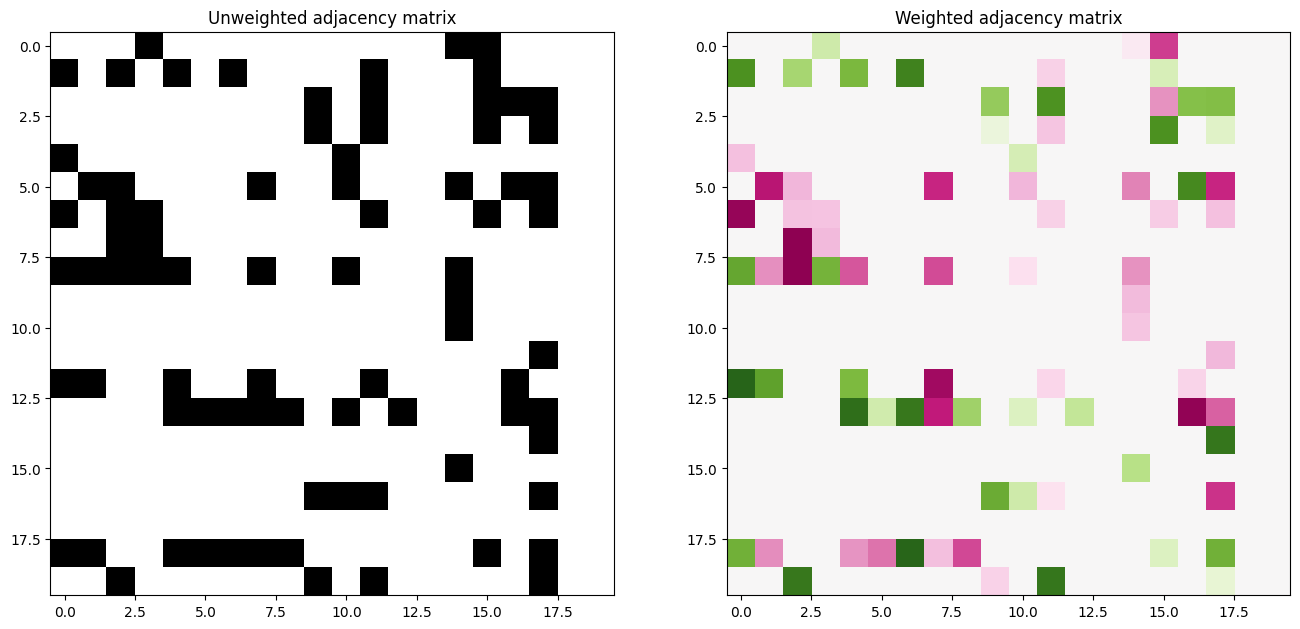

In [3]:
# Initiating the random DAG
B_true = data_generation.simulate_dag(d, k * d, graph_type) # Erdös-Renyi graph simulation with avg degree = k

# Initializing weights on the adjacency matrix
W_true = data_generation.simulate_parameter(B_true, w_ranges=((-b, -a), (a, b))) # sampling uniformly the weights

# Visualizing the adjacency matrix
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 10)

ax1.imshow(B_true, cmap='Greys') # blue = non-zero
ax1.set_title('Unweighted adjacency matrix')

ax2.imshow(W_true, cmap='PiYG') # green = positive, pink = negative
ax2.set_title("Weighted adjacency matrix")

Text(0.5, 1.0, 'Data samples')

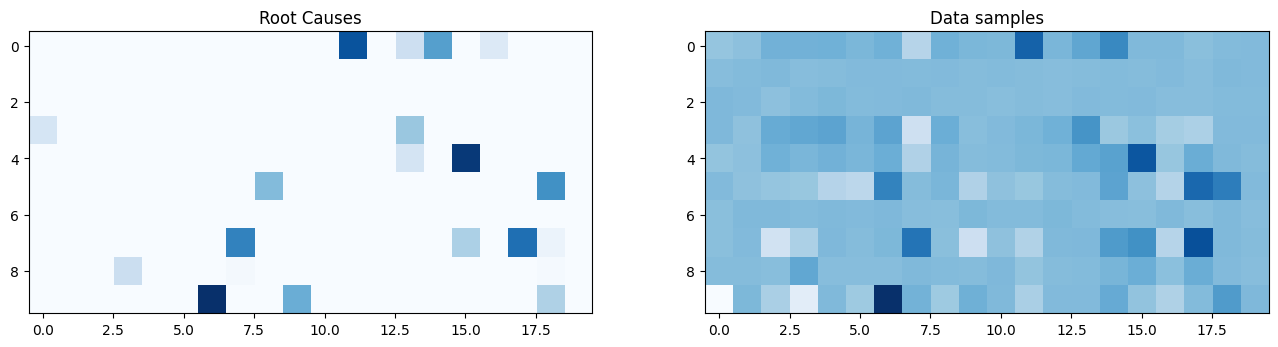

In [4]:
X, C_true, cond_num = data_generation.sparse_rc_sem(W_true, n, sparsity=0.1, std=0.01, 
                    noise_type="gauss", noise_effect=noise_effect, fix_sup=fixSup)

# Visualizing the root causes and the data 
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 10)

# Picking the first 10 samples for visualization purposes
ax1.imshow(C_true[:10], cmap='Blues') # blue = non-zero
ax1.set_title('Root Causes')

ax2.imshow(X[:10], cmap='Blues') # green = positive, pink = negative
ax2.set_title("Data samples")

## Causal Discovery

In [5]:
# Retrieving the DAG adjacency matrix with SparseRC solver.
start = time.time()

# retrieving the weighted adjacency matrix
W_est = sparserc_solver(X, lambda1=0, lambda2=1, epochs=sparserc_epochs, omega=omega) 
# W_est is already thresholded: all entries with absolut value less than omega are set to 0.

T = time.time() - start
B_est = W_est != 0 # adjacency matrix

Epoch: 0. Loss = 2.661
Epoch: 10. Loss = 2.495
Epoch: 20. Loss = 2.344
Epoch: 30. Loss = 2.206
Epoch: 40. Loss = 2.081
Epoch: 50. Loss = 1.966
Epoch: 60. Loss = 1.862
Epoch: 70. Loss = 1.768
Epoch: 80. Loss = 1.683
Epoch: 90. Loss = 1.606
Epoch: 100. Loss = 1.536
Epoch: 110. Loss = 1.473
Epoch: 120. Loss = 1.415
Epoch: 130. Loss = 1.363
Epoch: 140. Loss = 1.317
Epoch: 150. Loss = 1.275
Epoch: 160. Loss = 1.239
Epoch: 170. Loss = 1.207
Epoch: 180. Loss = 1.177
Epoch: 190. Loss = 1.150
Epoch: 200. Loss = 1.126
Epoch: 210. Loss = 1.104
Epoch: 220. Loss = 1.083
Epoch: 230. Loss = 1.064
Epoch: 240. Loss = 1.046
Epoch: 250. Loss = 1.030
Epoch: 260. Loss = 1.015
Epoch: 270. Loss = 1.000
Epoch: 280. Loss = 0.987
Epoch: 290. Loss = 0.974
Epoch: 300. Loss = 0.962
Epoch: 310. Loss = 0.951
Epoch: 320. Loss = 0.940
Epoch: 330. Loss = 0.929
Epoch: 340. Loss = 0.919
Epoch: 350. Loss = 0.910
Epoch: 360. Loss = 0.901
Epoch: 370. Loss = 0.893
Epoch: 380. Loss = 0.885
Epoch: 390. Loss = 0.877
Epoch: 400.

## Evaluation

Text(0.5, 1.0, 'SparseRC (weighted)')

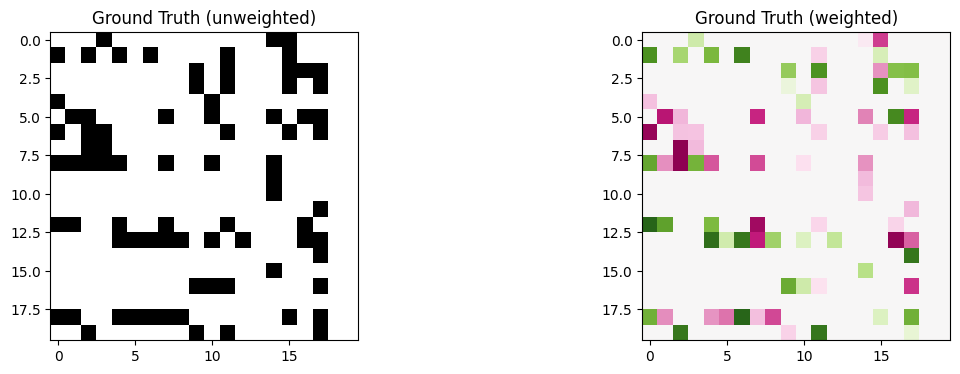

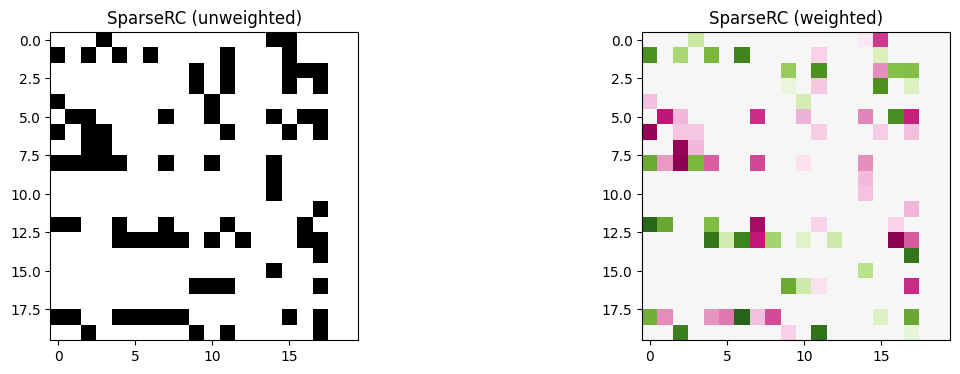

In [6]:
# Visualizing the original adjacency matrix
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14, 4)

ax1.imshow(B_true, cmap='Greys') # blue = non-zero
ax1.set_title('Ground Truth (unweighted)')

ax2.imshow(W_true, cmap='PiYG') # green = positive, pink = negative
ax2.set_title("Ground Truth (weighted)")

# Note:
# for larger graphs the dpi imshow analysis must be set accordingly (higher).

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14, 4)

ax1.imshow(B_est, cmap='Greys') # blue = non-zero
ax1.set_title('SparseRC (unweighted)')

ax2.imshow(W_est, cmap='PiYG') # green = positive, pink = negative
ax2.set_title('SparseRC (weighted)')

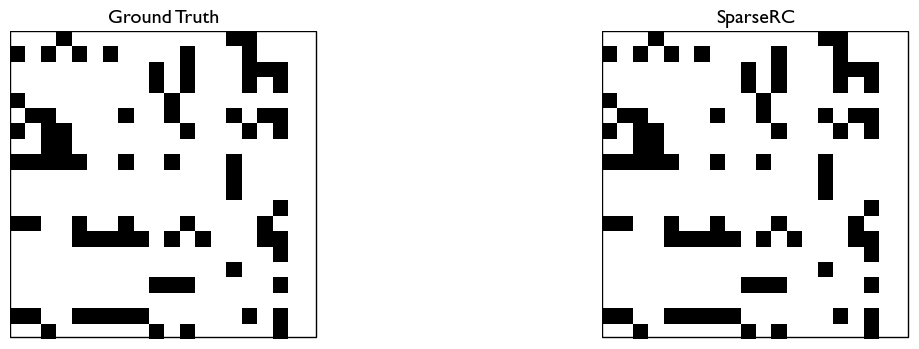

In [7]:
# Visualizing the errors
visualize(B_true, W_est, "sparserc", "visualization.png")

# Black = correct edge
# White = correctly absent edge

# Errors (if any):
# Red = wrong edge
# Grey = missing edge


TP = 1823, P = 2063, FP = 0, N = 17937
SparseRC performance evaluation
Data on graph with 1000 nodes and consisting of 20 samples


----- Graph Metrics -------
Structural Hamming Distance 0.000
Total edges proposed 80.000
False Discovery Rate 0.000
True Positive Rate 1.000
Normalized mean-square error on approximation of weighted adjacency0.046


----- Root causes metrics -------
Normalized mean-square error on approximation of root causes 0.046
True Positive Rate on the root causes support 0.884
False Positive Rate on the root causes support 0.000


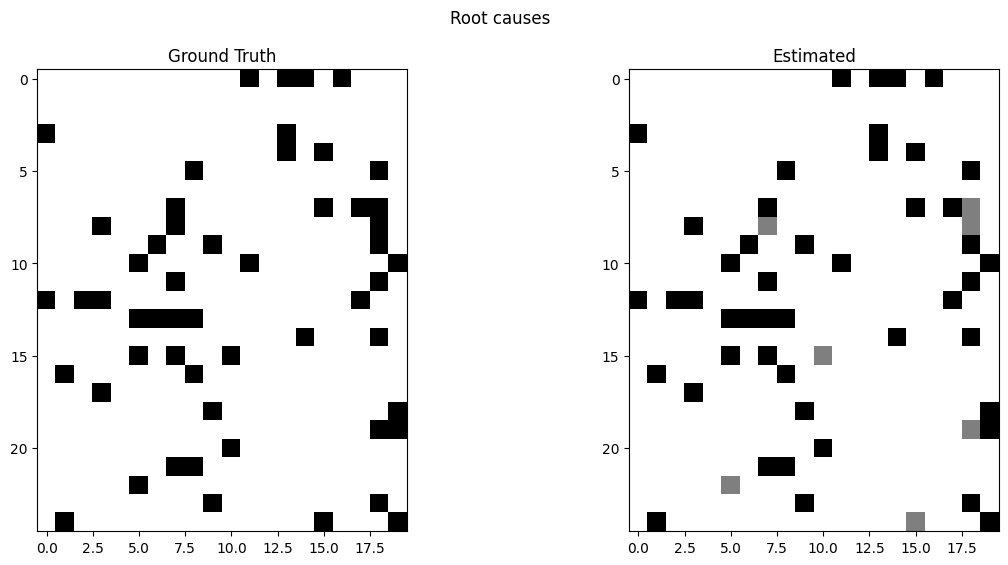

In [8]:
# Computing the performance metrics 
metrics = count_accuracy(B_true, B_est)
nmse = np.linalg.norm(W_est - W_true) / np.linalg.norm(W_true)

# # only uncomment if have cdt package correctly installed and set-up
# shd = cdt.metrics.SHD(B_true, B_est, double_for_anticausal=False)
# sid = cdt.metrics.SID(B_true, B_est) if d < 200 else 0 # sid is too expensive

# Evaluating the approximation of the root causes 
rc_nmse, support_tpr, support_fpr = rc_approximation('sparserc', X, W_est, C_true)
# visualizing first 25 root causes samples vs approximation.

print("SparseRC performance evaluation")
print("Data on graph with {} nodes and consisting of {} samples".format(n,d))
print("\n")
print("----- Graph Metrics -------")
print("Structural Hamming Distance {:.3f}".format(metrics["shd"]))
print("Total edges proposed {:.3f}".format(metrics["nnz"]))
print("False Discovery Rate {:.3f}".format(metrics["fdr"]))
print("True Positive Rate {:.3f}".format(metrics["tpr"]))
print("Normalized mean-square error on approximation of weighted adjacency {:.3f}".format(nmse))
# # only uncomment if have cdt package correctly installed and set-up
# print("Structural Hamming Distance (Causal Discovery Toolbox) {:.3f}".format(shd))
# print("Structural Interventional Distance (Causal Discovery Toolbox) {:.3f}".format(sid))
print("\n")
print("----- Root causes metrics -------")
print("Normalized mean-square error on approximation of root causes {:.3f}".format(nmse))
print("True Positive Rate on the root causes support {:.3f}".format(support_tpr))
print("False Positive Rate on the root causes support {:.3f}".format(support_fpr))